## FINAL PROJECT - 02456 DEEP LEARNING
### SEGMENTATION OF CAR PARTS 
### COLLABORATION WITH DELOITTE CONSULTING

#### Authors
>*Sanem Leblebici - s222448*

>*Michal Lehwark - s222999*

>*Ari Menachem - s163956*

>*Elli Georgiou - s223408*


In [18]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
from modules.model import UNET
from modules.settings import DATA_PATH, NUM_EPOCHS,BATCH_SIZE,SPLIT_RATIO, LEARNING_RATE, device
from modules.utils import get_data_loaders
from modules.resizeImages import resize_with_pad
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import os
import cv2
from typing import Tuple
from torchsummary import summary
from torchvision import transforms as T


### Load the trained model

In [19]:
mdl = UNET()

## Can uncomment the next line if your device has gpu
# mdl.load_state_dict(torch.load('./models/unet_nov18.pth'))

mdl.load_state_dict(torch.load('./models/nov23/unet_nov23_4.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### TEST LOOP

In [31]:

test_folder_path = './data/carseg_data/images/photo/no_segmentation'  # Replace with the actual path
masks_path = './data/carseg_data/arrays'

# Create a list to store the model outputs
model_outputs = []
model_outputs_images = []
model_outputs_gt = []

# Set the model to evaluation mode
mdl.eval()

# Define the transformation to be applied to the input images
transform = transforms.Compose([transforms.ToTensor()])
how_many_images_to_test = 10
index = 0

# Iterate through the images in the test folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(test_folder_path, filename)
        
        name, ext = filename.split('.')
        mask_string = "photo_" + name + ".npy"
        mask_path = os.path.join(masks_path, mask_string)
        mask = np.load(mask_path)
        
        print("initial mask shape ", mask.shape)
        img = mask[:, :, :3]
        print("image shape ", img.shape)
        mask_split = mask[:, :, 3]
        print("mask shape ", mask_split.shape)
        mask_split = mask_split//10
        mask_split = mask_split.astype(int)
        one_hot_encoded = np.eye(10, dtype=int)[mask_split.squeeze()]
        print("mask unique ", np.unique(one_hot_encoded))
        
        img = transform(img)
        print("img shape after tra", img.shape)
            
        mdl.eval()
        # Make the prediction
        with torch.no_grad():
            img = img.unsqueeze(0)
            output = mdl(img)
            print(output.shape)
            print(torch.unique(output[0][0][0][0]))
            print(torch.unique(output[0][1][0][0]))
            print(torch.unique(output[0][2][0][0]))
            print(torch.unique(output[0][3][0][0]))
            print(torch.unique(output[0][4][0][0]))
            print(torch.unique(output[0][5][0][0]))
            print(torch.unique(output[0][6][0][0]))
            print(torch.unique(output[0][7][0][0]))
            print(torch.unique(output[0][8][0][0]))
            argmax_output = torch.argmax(output, dim=1)
            print('---')
            print(torch.unique(argmax_output[0][0][0]))
            print(argmax_output.shape)
            print(torch.unique(argmax_output[0]))

        # Store the output in the list
        model_outputs.append(argmax_output[0])
        model_outputs_images.append(img)
        model_outputs_gt.append(mask_split)

        #detect for first 10 images
        if index == how_many_images_to_test:
          break
        index = index + 1

# The `model_outputs` list now contains the model's output for each test image

initial mask shape  (256, 256, 4)
image shape  (256, 256, 3)
mask shape  (256, 256)
mask unique  [0 1]
img shape after tra torch.Size([3, 256, 256])
torch.Size([1, 10, 256, 256])
tensor([0.6702])
tensor([-1.1276])
tensor([1.1753])
tensor([-0.2758])
tensor([0.1909])
tensor([0.3948])
tensor([1.3709])
tensor([-0.1729])
tensor([0.2431])
---
tensor([6])
torch.Size([1, 256, 256])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
initial mask shape  (256, 256, 4)
image shape  (256, 256, 3)
mask shape  (256, 256)
mask unique  [0 1]
img shape after tra torch.Size([3, 256, 256])
torch.Size([1, 10, 256, 256])
tensor([0.6195])
tensor([-1.4642])
tensor([1.4861])
tensor([-0.3100])
tensor([0.0425])
tensor([0.7209])
tensor([1.0309])
tensor([-0.4468])
tensor([0.2279])
---
tensor([2])
torch.Size([1, 256, 256])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
initial mask shape  (256, 256, 4)
image shape  (256, 256, 3)
mask shape  (256, 256)
mask unique  [0 1]
img shape after tra torch.Size([3, 256, 256])
torch.Size([1, 10, 

### COLORFUL SEGMENTATION PLOT AND LOSS PLOTS

In [21]:
def plot_loss_from_txt(file_path):
    # Read data from the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract data from each line
    indices, train_losses, val_losses = [], [], []
    for line in lines[1:]:  # Assuming the first line contains column headers
        index, train_loss, val_loss = map(float, line.strip().split())
        indices.append(index)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(indices, train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(indices, val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

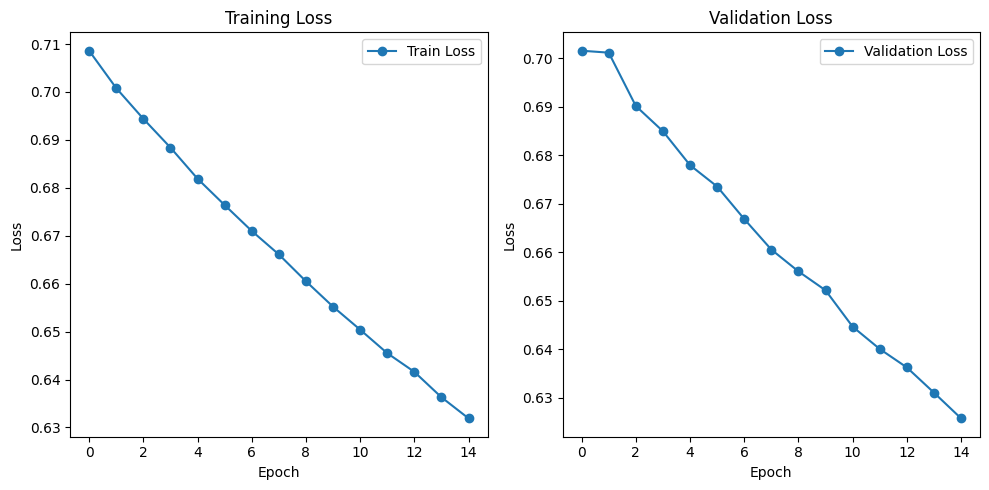

In [22]:
plot_loss_from_txt('./models/nov23/loss_data_nov23_4.txt')

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 1 2 3 4 5 7 8 9]
(256, 256)


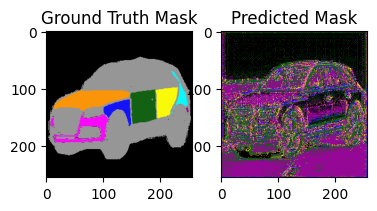

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 2 3 4 5 6 7 8 9]
(256, 256)


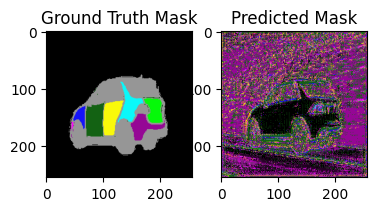

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 1 2 3 4 5 7 8 9]
(256, 256)


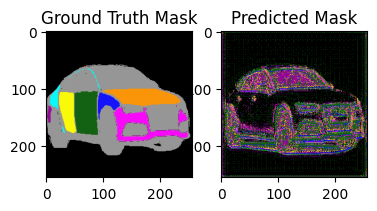

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 2 4 5 6 9]
(256, 256)


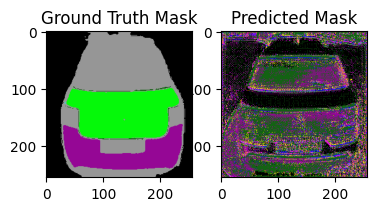

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 1 2 3 4 5 7 8 9]
(256, 256)


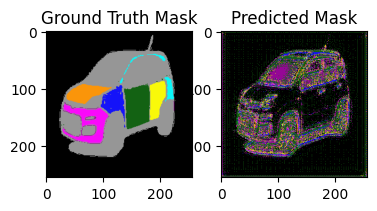

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 1 2 4 5 7 8 9]
(256, 256)


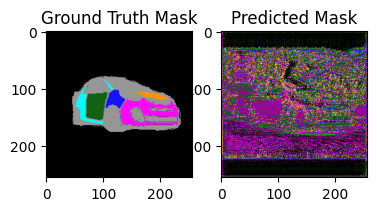

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 2 3 4 5 6 7 8 9]
(256, 256)


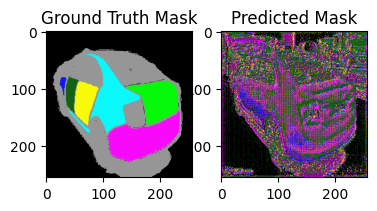

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 1 2 3 4 5 7 8 9]
(256, 256)


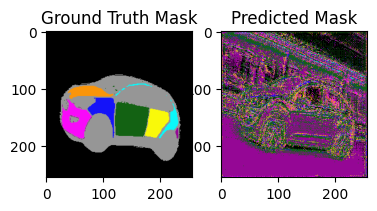

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 1 2 3 4 5 7 8 9]
(256, 256)


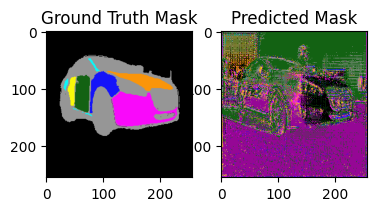

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([256, 256])
[0 2 3 4 5 6 7 9]
(256, 256)


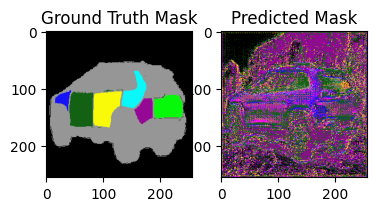

In [34]:
# Define color mapping for each class
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }

def colorize_segmentation_mask(segmentation_tensor_or_mask, mask = False):
    # Convert the PyTorch tensor to a NumPy array
    if mask == False:
        segmentation_array = segmentation_tensor_or_mask.squeeze(0).cpu().numpy()
        
    else:
        segmentation_array = segmentation_tensor_or_mask

    # Create a mapping from actual class values to color values
    class_to_color = {class_value: color_mapping[class_value] for class_value in np.unique(segmentation_array)}

    # Create an RGB image with the colored segmentation mask
    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_value, color in class_to_color.items():
        colored_mask[segmentation_array == class_value] = color

    return colored_mask

for image_index_to_display in range(10):
    segmentation_tensor = model_outputs[image_index_to_display]
    mask_tensor = model_outputs_gt[image_index_to_display]
    print(torch.unique(segmentation_tensor))
    print(segmentation_tensor.shape)
    print(np.unique(mask_tensor))
    print(mask_tensor.shape)

    plt.subplot(1, 3, 2)
    plt.imshow(colorize_segmentation_mask(mask_tensor, True))
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(colorize_segmentation_mask(segmentation_tensor))
    plt.title('Predicted Mask')

    plt.show()

### TESTING THE PREPROCESSING OF THE MASK

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


output shape  torch.Size([10, 256, 256])
output unique  tensor([0., 1.])
argmax shape  torch.Size([256, 256])
argmax unique  tensor([0, 1, 2, 3, 4, 5, 7, 8, 9])


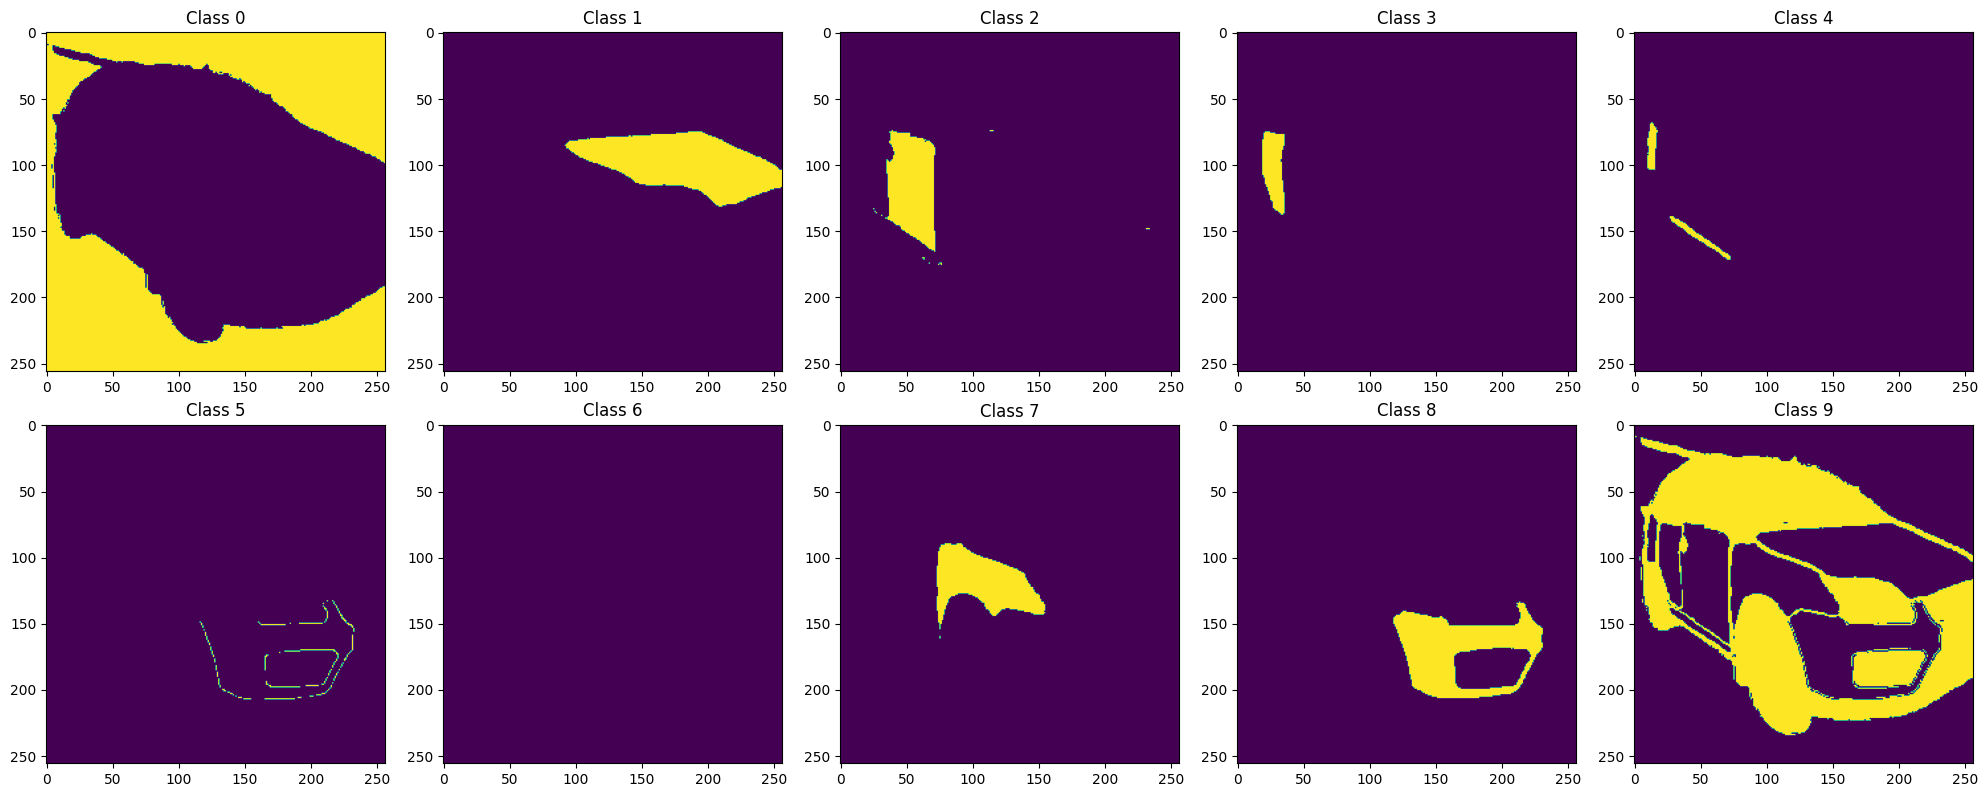

In [35]:
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }


#### WHAT WE DO IN DATASET ######
img_path = './data/carseg_data/images/photo/no_segmentation/0045.jpg'
mask_path = './data/carseg_data/arrays/photo_0045.npy'


mask = np.load(mask_path).astype(np.double)
img = mask[:, :, :3]
mask_split = mask[:, :, 3]
mask_split = mask_split//10
mask_split = mask_split.astype(int)
        
        
transform = T.Compose([T.ToTensor()])
img = transform(img)
        
one_hot_encoded = np.eye(10, dtype=int)[mask_split.squeeze()]
ms = torch.from_numpy(one_hot_encoded)
        
img = img.to(torch.float32)
reshaped_mask_tensor = ms.permute(2, 0, 1)
reshaped_mask_tensor = reshaped_mask_tensor.to(torch.float32)
        



#### NOW YOU CAN COMPRESS IT BACK IN THIS WAY SHOWING 10 UNIQUE CLASSES: SO IT WORKS CORRECTLY####
print("output shape ", reshaped_mask_tensor.shape)
print("output unique ", torch.unique(reshaped_mask_tensor))
argmax_output = torch.argmax(reshaped_mask_tensor, dim=0).long()
print("argmax shape ", argmax_output.shape)
print("argmax unique ", torch.unique(argmax_output))
#### NOW YOU CAN COMPRESS IT BACK IN THIS WAY SHOWING 10 UNIQUE CLASSES: SO IT WORKS CORRECTLY####






##### PLOT THE MASK THAT IS FED INTO THE MODEL ####
# Plotting
num_classes = 10
num_rows = (num_classes + 4) // 5  # Ensure at least 1 row, with max 5 columns
fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))

# Plot original mask
axes[0, 0].imshow(mask, cmap='viridis', vmin=0, vmax=9)
axes[0, 0].set_title('Original Mask')

# Plot one-hot encoded tensors for each class
for i in range(1, num_classes + 1):
    row = (i - 1) // 5
    col = (i - 1) % 5
    axes[row, col].imshow(reshaped_mask_tensor[i - 1, :, :], cmap='viridis', vmin=0, vmax=1)
    axes[row, col].set_title(f'Class {i - 1}')

# Hide empty subplots if necessary
for i in range(num_classes, num_rows * 5):
    row = i // 5
    col = i % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
##### PLOT THE MASK THAT IS FED INTO THE MODEL ####


### CHECKING IF DELOITTE GAVE US GOOD MASKS

/var/folders/mt/36j75y4n7xz6rfcxjxyyk60m0000gn/T/ipykernel_2478/336541153.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


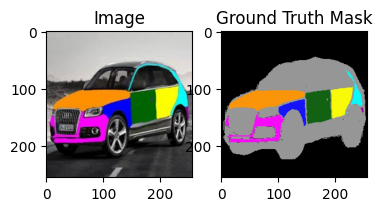

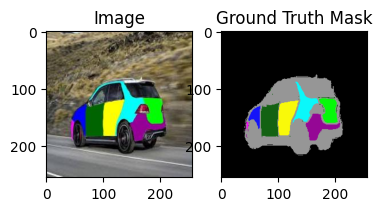

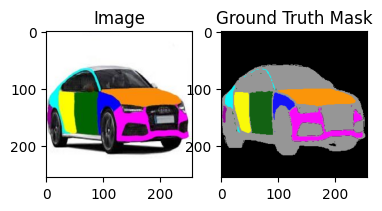

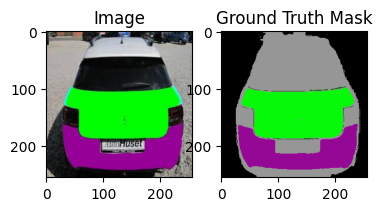

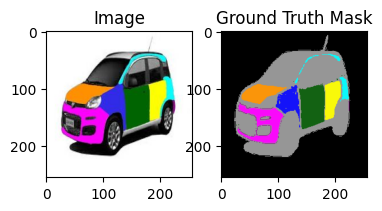

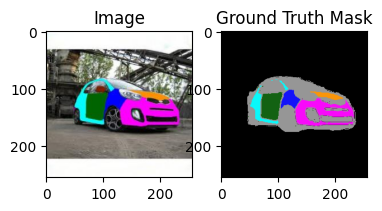

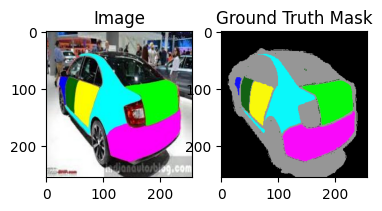

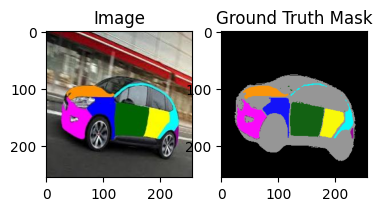

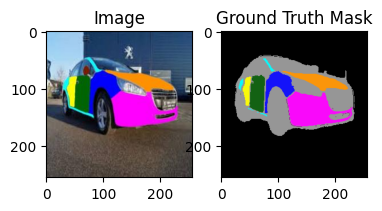

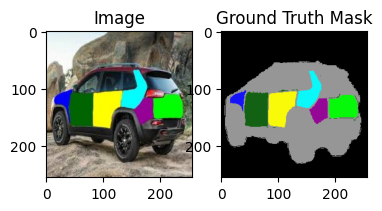

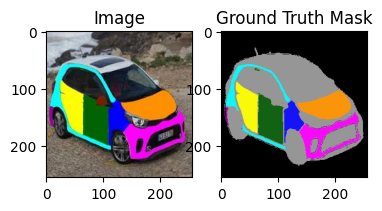

In [77]:
orange_im_path = "./data/carseg_data/images/photo/with_segmentation"
black_im_path = "./data/carseg_data/images/photo/with_segmentation"
photo_im_path = "./data/carseg_data/images/photo/with_segmentation"

mask_name = "photo_"

#### CHECKING THE ORANGE CAR DATA 
index = 0 
for im in os.listdir(photo_im_path):

    if im.endswith(".jpg") or im.endswith(".png"):
        # Load the image
        image_path = os.path.join(photo_im_path, im)
        
        name, ext = im.split('.')
        mask_string = mask_name + name + ".npy"
        mask_path = os.path.join('/Users/sanemleblebici/Desktop/deep_learning_project/data/carseg_data/arrays', mask_string)
        mask = np.load(mask_path)
        mask = mask//10
        
        img = cv2.imread(image_path)
        resized = resize_with_pad(img, (256, 256))
        img_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        colorize_segmentation_mask(mask, mask=True)
        plt.imshow(img_rgb)
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        # img_rgb = cv2.cvtColor(model_outputs_images[image_index_to_display], cv2.COLOR_BGR2RGB)
        plt.imshow(colorize_segmentation_mask(mask, mask=True))
        plt.title('Ground Truth Mask')

        if index == 10:
            break
        index = index + 1
        
    plt.show() 
        